In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 检查 GPU 是否可用
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is available


### Data Preparation

In [3]:
raw_data = pd.read_csv(r'C:\Users\Georg\Desktop\TTRS\00-Github\2-EMS\Forecasting\data\load_data.csv', 
                        index_col='Time', parse_dates=True, encoding_errors='ignore')

In [4]:
raw_data

,load,workday,temp
Time,,,
2024-03-01 00:00:00,202.60,1,4.8
2024-03-01 00:15:00,178.90,1,4.7
2024-03-01 00:30:00,164.30,1,4.6
2024-03-01 00:45:00,170.40,1,4.6
2024-03-01 01:00:00,191.50,1,4.5
...,...,...,...
2024-12-31 22:45:00,217.00,1,4.4
2024-12-31 23:00:00,265.30,1,4.5
2024-12-31 23:15:00,243.40,1,4.6


In [5]:
raw_data = raw_data[raw_data['load']!=0]
raw_data = raw_data[raw_data['temp']>0]

In [6]:
# 定义一个函数来确定季节
def get_season(month):
    if month in [12, 1, 2]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4

# 提取月份并应用函数
raw_data['Month'] = raw_data.index.month
raw_data['Season'] = raw_data.index.month.map(get_season)

# 查看结果
print(raw_data.head())

                      load  workday  temp  Month  Season
Time                                                    
2024-03-01 00:00:00  202.6        1   4.8      3       2
2024-03-01 00:15:00  178.9        1   4.7      3       2
2024-03-01 00:30:00  164.3        1   4.6      3       2
2024-03-01 00:45:00  170.4        1   4.6      3       2
2024-03-01 01:00:00  191.5        1   4.5      3       2


In [7]:
load_data = raw_data.copy()
# # 数据预处理
scaler1 = MinMaxScaler()  # 使用 MinMaxScaler 进行特征缩放
scaler2 = MinMaxScaler()
# load_data[['real_load', 'Temperature', 'Humidity']] = scaler.fit_transform(load_data[['real_load', 'Temperature', 'Humidity']])
load_data[['load']] = scaler1.fit_transform(load_data[['load']])
load_data[['temp']] = scaler2.fit_transform(load_data[['temp']])


# # 缺失值处理（如果需要）
load_data.fillna(method='ffill', inplace=True)  # 使用前一个值填充缺失值

# # 特征选择
# input_cols = ['real_load','IsWeekend','Temperature','Humidity',]
input_cols = ['load','workday','temp', 'Season']
# input_cols = ['load']



# 创建输入输出序列
def create_sequences(data, seq_length, target_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length - target_length):
        x = data[i:(i + seq_length)].values
        y = data['load'][(i + seq_length):(i + seq_length + target_length)].values
        # y = data.loc[(i + seq_length):(i + seq_length + target_length), 'real_load'].values
        if i == 0:
            print(x.shape, y.shape)
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 96*7   # 使用前七天的数据作为输入
target_length = 96  # 预测未来一天的负荷

X, y = create_sequences(load_data[input_cols], seq_length, target_length)
print(X.shape, y.shape)
# # 划分训练集和验证集
# train_size = int(0.8 * len(X))
# X_train, X_val = X[:train_size], X[train_size:]
# y_train, y_val = y[:train_size], y[train_size:]

# 计算边界
total_size = len(X)
train_size_1 = int(0.6 * total_size)
train_size_2 = int(0.85 * total_size)

# 划分训练集、测试集
X_train = np.concatenate((X[:train_size_1], X[train_size_2:]))
y_train = np.concatenate((y[:train_size_1], y[train_size_2:]))
X_test = X[train_size_1:train_size_2]
y_test = y[train_size_1:train_size_2]

# 构建 DataLoader
train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)

for i, batch in enumerate(val_loader):
    if i == 0:
        inputs, labels = batch
        print(labels[0])
        print(inputs[0])
        print(inputs.shape, labels.shape)


(672, 4) (96,)
(24693, 672, 4) (24693, 96)
tensor([0.1453, 0.1670, 0.1669, 0.1612, 0.1578, 0.1743, 0.1872, 0.1769, 0.2071,
        0.2196, 0.2218, 0.2141, 0.2022, 0.2115, 0.2108, 0.2059, 0.3154, 0.3785,
        0.3646, 0.3790, 0.3373, 0.4672, 0.4970, 0.6164, 0.5684, 0.5851, 0.6188,
        0.6631, 0.6260, 0.6402, 0.6842, 0.6419, 0.6535, 0.6698, 0.6333, 0.6608,
        0.6737, 0.6257, 0.6347, 0.5756, 0.6340, 0.6285, 0.6630, 0.6563, 0.6859,
        0.6127, 0.5945, 0.6083, 0.6263, 0.6468, 0.6121, 0.5794, 0.5773, 0.5343,
        0.5334, 0.5154, 0.4934, 0.4506, 0.5195, 0.4990, 0.5081, 0.5027, 0.4723,
        0.4487, 0.4617, 0.4676, 0.4649, 0.4440, 0.4517, 0.4332, 0.4500, 0.4427,
        0.4406, 0.4363, 0.4270, 0.4277, 0.4205, 0.4194, 0.4320, 0.4094, 0.4136,
        0.3456, 0.2386, 0.2175, 0.2102, 0.2196, 0.1946, 0.1757, 0.1951, 0.1626,
        0.1407, 0.1396, 0.1447, 0.1361, 0.1512, 0.1361])
tensor([[0.2312, 1.0000, 0.6244, 4.0000],
        [0.2284, 1.0000, 0.6244, 4.0000],
        [0.2242,

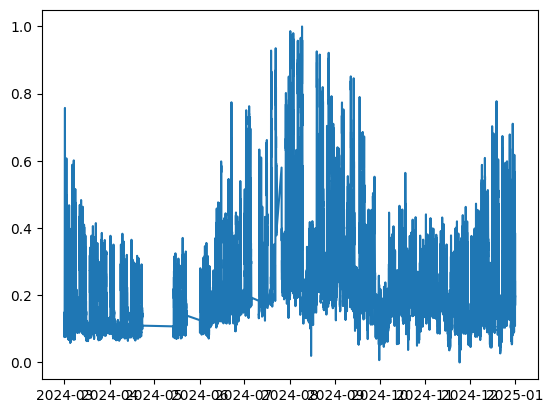

In [8]:
plt.plot(load_data['load'])

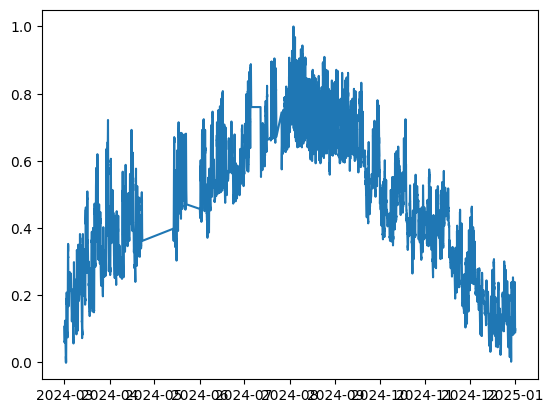

In [9]:
plt.plot(load_data['temp'])

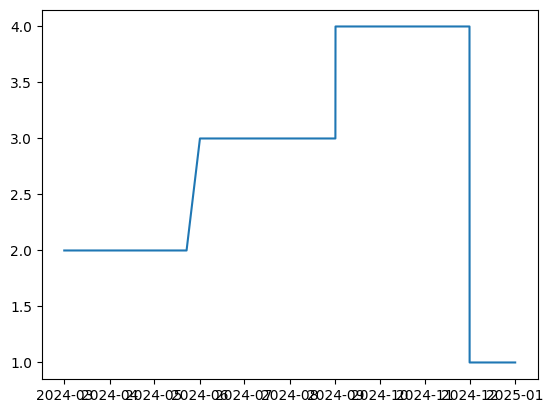

In [10]:
plt.plot(load_data['Season'])

### Model Constrcution

In [11]:
class MAPELoss(nn.Module):
    def __init__(self):
        super(MAPELoss, self).__init__()

    def forward(self, output, target):
        output = output.float()
        target = target.float()
        mape = torch.abs((output - target) / (target+1e-6))
        return torch.mean(mape)

In [12]:

class ConvBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size=3, padding=1, pool_size=2):
        super().__init__()
        self.conv = nn.Conv1d(input_dim, hidden_dim, kernel_size, padding=padding)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(pool_size)

    def forward(self, x):
        return self.pool(self.relu(self.conv(x)))  # More concise forward pass

In [13]:
class ForecastingEncoder(nn.Module):
    """The RNN encoder for sequence-to-sequence learning.

    Defined in :numref:`sec_seq2seq`"""
    def __init__(self, num_features, num_hiddens, num_layers,
                 bidirectional = False, dropout=0):
        super().__init__()
        self.rnn = nn.GRU(input_size = num_features, hidden_size = num_hiddens, num_layers = num_layers,
                      batch_first=False, bidirectional = bidirectional, dropout=dropout)

    def forward(self, X, *args):
        # X shape: (batch_size, num_steps, num_features)
        outputs, state = self.rnn(X)
        # print('inner outputs shape',outputs.shape)
        # print('inner state shape',state.shape)
        # outputs shape: (num_steps, batch_size, num_hiddens)
        # state shape: (num_layers, batch_size, num_hiddens)
        return outputs, state

In [14]:
class AdditiveAttention(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1, encoder_bi = True):
        super().__init__()
        num_encoder_dire = 2 if encoder_bi else 1
        self.W_q = nn.Linear(hidden_dim, hidden_dim*num_encoder_dire, bias=False)  # No bias needed for the query
        self.W_k = nn.Linear(hidden_dim*num_encoder_dire, hidden_dim*num_encoder_dire, bias=False)
        self.W_v = nn.Linear(hidden_dim*num_encoder_dire, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, query, keys, values,):
        # query的形状：(batch_size，查询的个数，num_hidden)
        # keys的形状：(batch_size，“键－值”对的个数，num_hiddens*2 if bi-directional else num_hiddens)
        queries, keys = self.W_q(query), self.W_k(keys)
        # print('inner queries.shape',queries.shape)
        # print('inner keys.shape',keys.shape)
        # 在维度扩展后，
        # queries的形状：(batch_size，查询的个数，1，num_hidden)
        # key的形状：(batch_size，1，“键－值”对的个数，num_hiddens)
        # 使用广播方式进行求和
        # features的形状：(batch_size，查询的个数，“键-值”对的个数，num_hiddens)
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        # print('inner features.shape',features.shape)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.W_v(features).squeeze(-1)
        self.attention_weights = F.softmax(scores,dim=-1)
        # print('inner self.attention_weights shape',self.attention_weights.shape)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        # print('inner values shape',values.shape)
        # context的形状：(batch_size，查询的个数，值的维度)
        context = torch.bmm(self.dropout(self.attention_weights), values) 
        # print('inner context.shape',context.shape)

        return context



In [15]:
class ForecastingEncoderDecoder(nn.Module):
    def __init__(self, num_features, hidden_dims, num_hiddens, num_layers, output_dim, num_steps, batch_size,
                 encoder_bi = False,dropout=0):
        super().__init__()
        self.conv_blocks = nn.ModuleList([
            ConvBlock(num_features if i == 0 else hidden_dims[i - 1], hidden_dims[i]) 
            for i in range(len(hidden_dims))])
        self.encoder = ForecastingEncoder(hidden_dims[-1], num_hiddens, num_layers, dropout=0.1)
        self.attention = AdditiveAttention(num_hiddens, dropout,encoder_bi=encoder_bi)
        self.decoder = nn.GRU(
            hidden_dims[-1] + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense1 = nn.Linear(num_hiddens, 1)
        self.dense2 = nn.LazyLinear(output_dim)
        self.activ = nn.Sigmoid()
        self.batch_size = batch_size
        self.output_dim = output_dim

    def init_state(self, enc_outputs):
        # Shape of outputs: (num_steps, batch_size, num_hiddens).
        # Shape of hidden_state: (num_layers, batch_size, num_hiddens)
        output, hidden_state = enc_outputs
        return (output.permute(1, 0, 2), hidden_state)

    def forward(self, X):
        for block in self.conv_blocks:
            X = block(X)
            # print(f"After {block.__class__.__name__}:", X.shape)
        # Encoder
        # Shape of the X: (num_steps, batch_size, hidden_dim[-1])
        X = X.permute(2, 0, 1)  # [batch, hidden_dim[-1], seq_len] -> [ seq_len, batch_size, hidden_dim[-1]]
        # print('X.shape',X.shape)

        # Shape of enc_out: (num_steps, batch_size, num_hiddens), (num_layers, batch_size, num_hiddens)
        enc_out= self.encoder(X)
        # print('encoder output shape',enc_out[0].shape, enc_out[1].shape)

        # Shape of state: (batch_size, num_steps, num_hiddens), (num_layers, batch_size, num_hiddens)
        state = self.init_state(enc_out)
        # print('initial state.shape',state[0].shape, state[1].shape)

        # Shape of enc_output: (batch_size, num_steps, num_hiddens)
        # Shape of hidden sttate: (num_layers, batch_size, num_hiddens)
        enc_output, hidden_state = state
        # print('enc_output.shape',enc_output.shape)

        
        # X = X.permute(1, 0, 2)
        # print('X.shape',X.shape)
        outputs, self._attention_weights = [], []
        for x in X:
            # print('x.shape',x.shape)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # print('query.shape',query.shape)
            # Shape of context: (batch_size, 1, num_hiddens)
            context = self.attention(
                query, enc_output, enc_output)
            # Concatenate on tshe feature dimension
            # print('context.shape',context.shape)
   
            # print(torch.unsqueeze(x, dim=1).shape)
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # print('renewed x shape',x.shape)
            # Reshape x as (1, batch_size, num_features + num_hiddens)
            out, hidden_state = self.decoder(x.permute(1, 0, 2), hidden_state)
            # print('out.shape',out.shape)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully connected layer transformation, shape of outputs:
        # outputs shape: (num_steps, batch_size, output_dim)
        outputs = torch.cat(outputs, dim=0)
        outputs = self.dense1(outputs).permute(1, 0, 2)
        # print('after dense1 outputs shape',outputs.shape)
        outputs = self.activ(self.dense2(outputs.squeeze(-1)))
        # print('Output has gradiants?', outputs.requires_grad)
        # # Shape of outputs: (batch_size, num_steps, output_dim)
        # print('outputs.shape',outputs.shape)
        return outputs, [enc_output, hidden_state]
    


    @property
    def attention_weights(self):
        return self._attention_weights
    
    def predict_steps(self, X, num_steps=288):
        predictions = torch.zeros((self.batch_size,self.output_dim)).to(device)
        for step in range(num_steps):
            # print('X.shape',X.shape)
            step_prediction,_ = self.forward(X)
            # print('step_prediction.shape',step_prediction.shape)
            X = torch.cat((X, step_prediction.unsqueeze(-1)), dim=-1)
            # print('X.shape',X.shape)
            X = X[:,:,1:]
            # print('X.shape',X.shape)
            predictions = torch.cat((predictions, step_prediction), dim=1)
        predictions = predictions[:,1:]

        return predictions

    @property
    def attention_weights(self):
        return self._attention_weights

### Model Training

In [16]:
# 定义早停类
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [17]:
# 初始化早停
early_stopping = EarlyStopping(patience=10, verbose=True)

criterion = nn.MSELoss()  # 使用均方误差作为损失函数
# criterion = nn.L1Loss()  # 使用平均绝对误差作为损失函数
# criterion = MAPELoss()  # 使用平均绝对百分比误差作为损失函数


num_features = 4  # 输入特征维度
hidden_dims = [16,32,64]  # 隐藏层维度
num_hiddens =  256 # GRU隐藏层维度
num_layers = 4  # GRU 层数
output_dim = 96  # 输出维度
batch_size = 128
seq_length = 96*7

# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=24, pin_memory=True)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False,num_workers=24, pin_memory=True)

model = ForecastingEncoderDecoder(num_features, hidden_dims, num_hiddens, num_layers, output_dim, seq_length, batch_size, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4)  # 使用 Adam 优化器

num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        data = data.permute(0, 2, 1)
        target = target.to(device)

        optimizer.zero_grad()
        output, state = model(data) 
        loss = criterion(output, target)
        # print(f"Batch {batch_idx}, Output: {output[:5]}, Target: {target[:5]}, Loss: {loss.item()}")  # 调试输出
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm = 1.0)
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}")

    # 在验证集上评估模型
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for data, target in val_loader:
            data = data.to(device)
            data = data.permute(0, 2, 1)
            target = target.to(device)

            output, state = model(data) 
            loss = criterion(output, target)
            val_loss += loss.item()

        val_loss /= len(val_loader)
        print(f"Validation Loss: {val_loss:.4f}")
        
        # 使用早停
        early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

Epoch 1/100, Loss: 0.0462
Validation Loss: 0.0114
Validation loss decreased (inf --> 0.011412).  Saving model ...
Epoch 2/100, Loss: 0.0196
Validation Loss: 0.0089
Validation loss decreased (0.011412 --> 0.008878).  Saving model ...
Epoch 3/100, Loss: 0.0190
Validation Loss: 0.0082
Validation loss decreased (0.008878 --> 0.008206).  Saving model ...
Epoch 4/100, Loss: 0.0185
Validation Loss: 0.0078
Validation loss decreased (0.008206 --> 0.007822).  Saving model ...
Epoch 5/100, Loss: 0.0178
Validation Loss: 0.0075
Validation loss decreased (0.007822 --> 0.007495).  Saving model ...
Epoch 6/100, Loss: 0.0170
Validation Loss: 0.0069
Validation loss decreased (0.007495 --> 0.006860).  Saving model ...
Epoch 7/100, Loss: 0.0164
Validation Loss: 0.0069
EarlyStopping counter: 1 out of 10
Epoch 8/100, Loss: 0.0160
Validation Loss: 0.0071
EarlyStopping counter: 2 out of 10
Epoch 9/100, Loss: 0.0158
Validation Loss: 0.0071
EarlyStopping counter: 3 out of 10
Epoch 10/100, Loss: 0.0155
Validatio

In [18]:
# 在验证集上进行预测
model.eval()
predictions = []
actual_values = []
with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
         # print(inputs.shape, labels.shape)
        inputs = inputs.to(device)
        inputs = inputs.permute(0, 2, 1)
        outputs, _ = model(inputs)
        labels = labels.to(device)
        loss = MAPELoss()(outputs, labels)

        predictions.append(outputs.cpu().numpy())
        actual_values.append(labels.cpu().numpy())
        # if i == 0 or i ==5 :
        #     print(outputs.shape, labels.shape)
        #     print(f"Predictions shape: {np.array(predictions).shape}")
        #     print(f"Actual values shape: {np.array(actual_values).shape}")
        loss += loss.item()
    
    loss /= len(val_loader)
    print(f"Validation MAPE Loss: {loss:.4f}")

predictions = np.concatenate(predictions)
actual_values = np.concatenate(actual_values)
# print(f"Predictions shape: {predictions.shape}")
# print(f"Actual values shape: {actual_values.shape}")


Validation MAPE Loss: 0.0150


In [ ]:
for name, param in model.named_parameters():
        print(f"Name: {name}, Shape: {param.shape}, Gradient Required: {param.requires_grad}",'Gradiant is not None:', param.grad != None)

#### Multiple Step Prediction Visualization

In [33]:
predictions.shape

(5709, 96)

In [49]:
predictions[0]

array([0.25123608, 0.24123827, 0.24272598, 0.23930618, 0.2221513 ,
       0.22500204, 0.22172901, 0.21615493, 0.20008667, 0.19270739,
       0.18353195, 0.18654418, 0.17852947, 0.18481697, 0.17498939,
       0.16769193, 0.1669138 , 0.1653681 , 0.16646795, 0.17072159,
       0.1682934 , 0.16786936, 0.16711518, 0.17252992, 0.1693126 ,
       0.1743014 , 0.1763831 , 0.1759438 , 0.17731532, 0.17498504,
       0.17949808, 0.18085119, 0.17832334, 0.17433661, 0.17788732,
       0.17302127, 0.16628078, 0.17077596, 0.1675768 , 0.15874003,
       0.15737714, 0.15506236, 0.15091103, 0.14935255, 0.14753234,
       0.13904823, 0.1395871 , 0.13817385, 0.13115688, 0.13593051,
       0.13550268, 0.13126571, 0.1300853 , 0.13051605, 0.13132729,
       0.12356834, 0.12282024, 0.12856194, 0.12536621, 0.13023664,
       0.1309582 , 0.13150492, 0.13624324, 0.13913962, 0.14035204,
       0.14555135, 0.15253896, 0.15695511, 0.16082716, 0.17086513,
       0.1771318 , 0.18200311, 0.19408487, 0.20230013, 0.20993

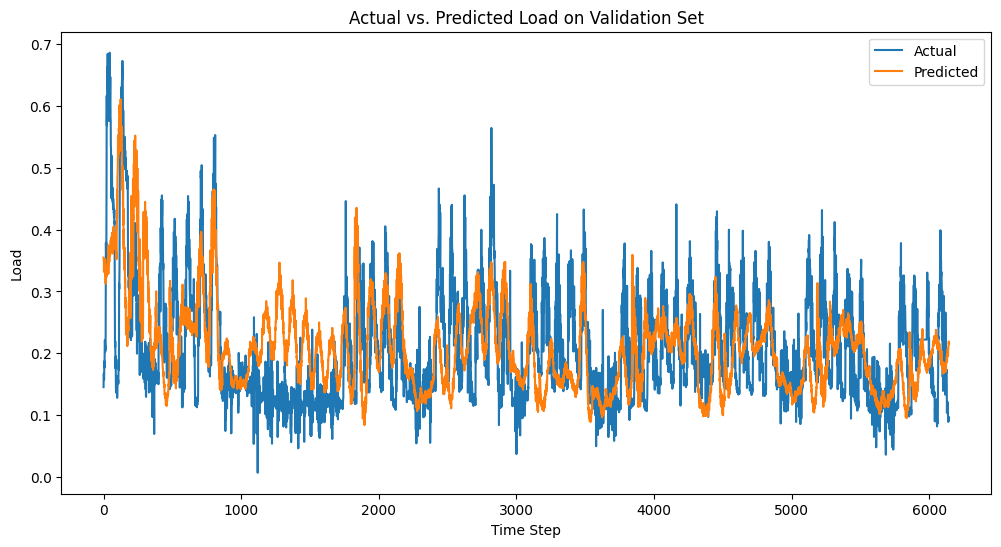

In [19]:
plot_predictions = []
plot_actual = []
predic_steps = 96

for i in range(len(predictions)//predic_steps):
    plot_predictions.append(predictions[i*predic_steps])
    plot_actual.append(actual_values[i*predic_steps])

plot_predictions = np.array(plot_predictions)
plot_actual = np.array(plot_actual)
# 可视化预测值和实际值
plt.figure(figsize=(12, 6))
plt.plot(plot_actual.flatten()[:], label='Actual')
plt.plot(plot_predictions.flatten()[:], label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.title('Actual vs. Predicted Load on Validation Set')
plt.show()

In [20]:
actual_load = scaler1.inverse_transform(plot_actual.flatten().reshape(-1, 1))
predicted_load = scaler1.inverse_transform(plot_predictions.flatten().reshape(-1, 1))

In [21]:
scaler1.inverse_transform(plot_actual.flatten().reshape(-1, 1))

array([[200.9    ],
       [215.17001],
       [215.09999],
       ...,
       [164.98   ],
       [166.20001],
       [168.32   ]], dtype=float32)

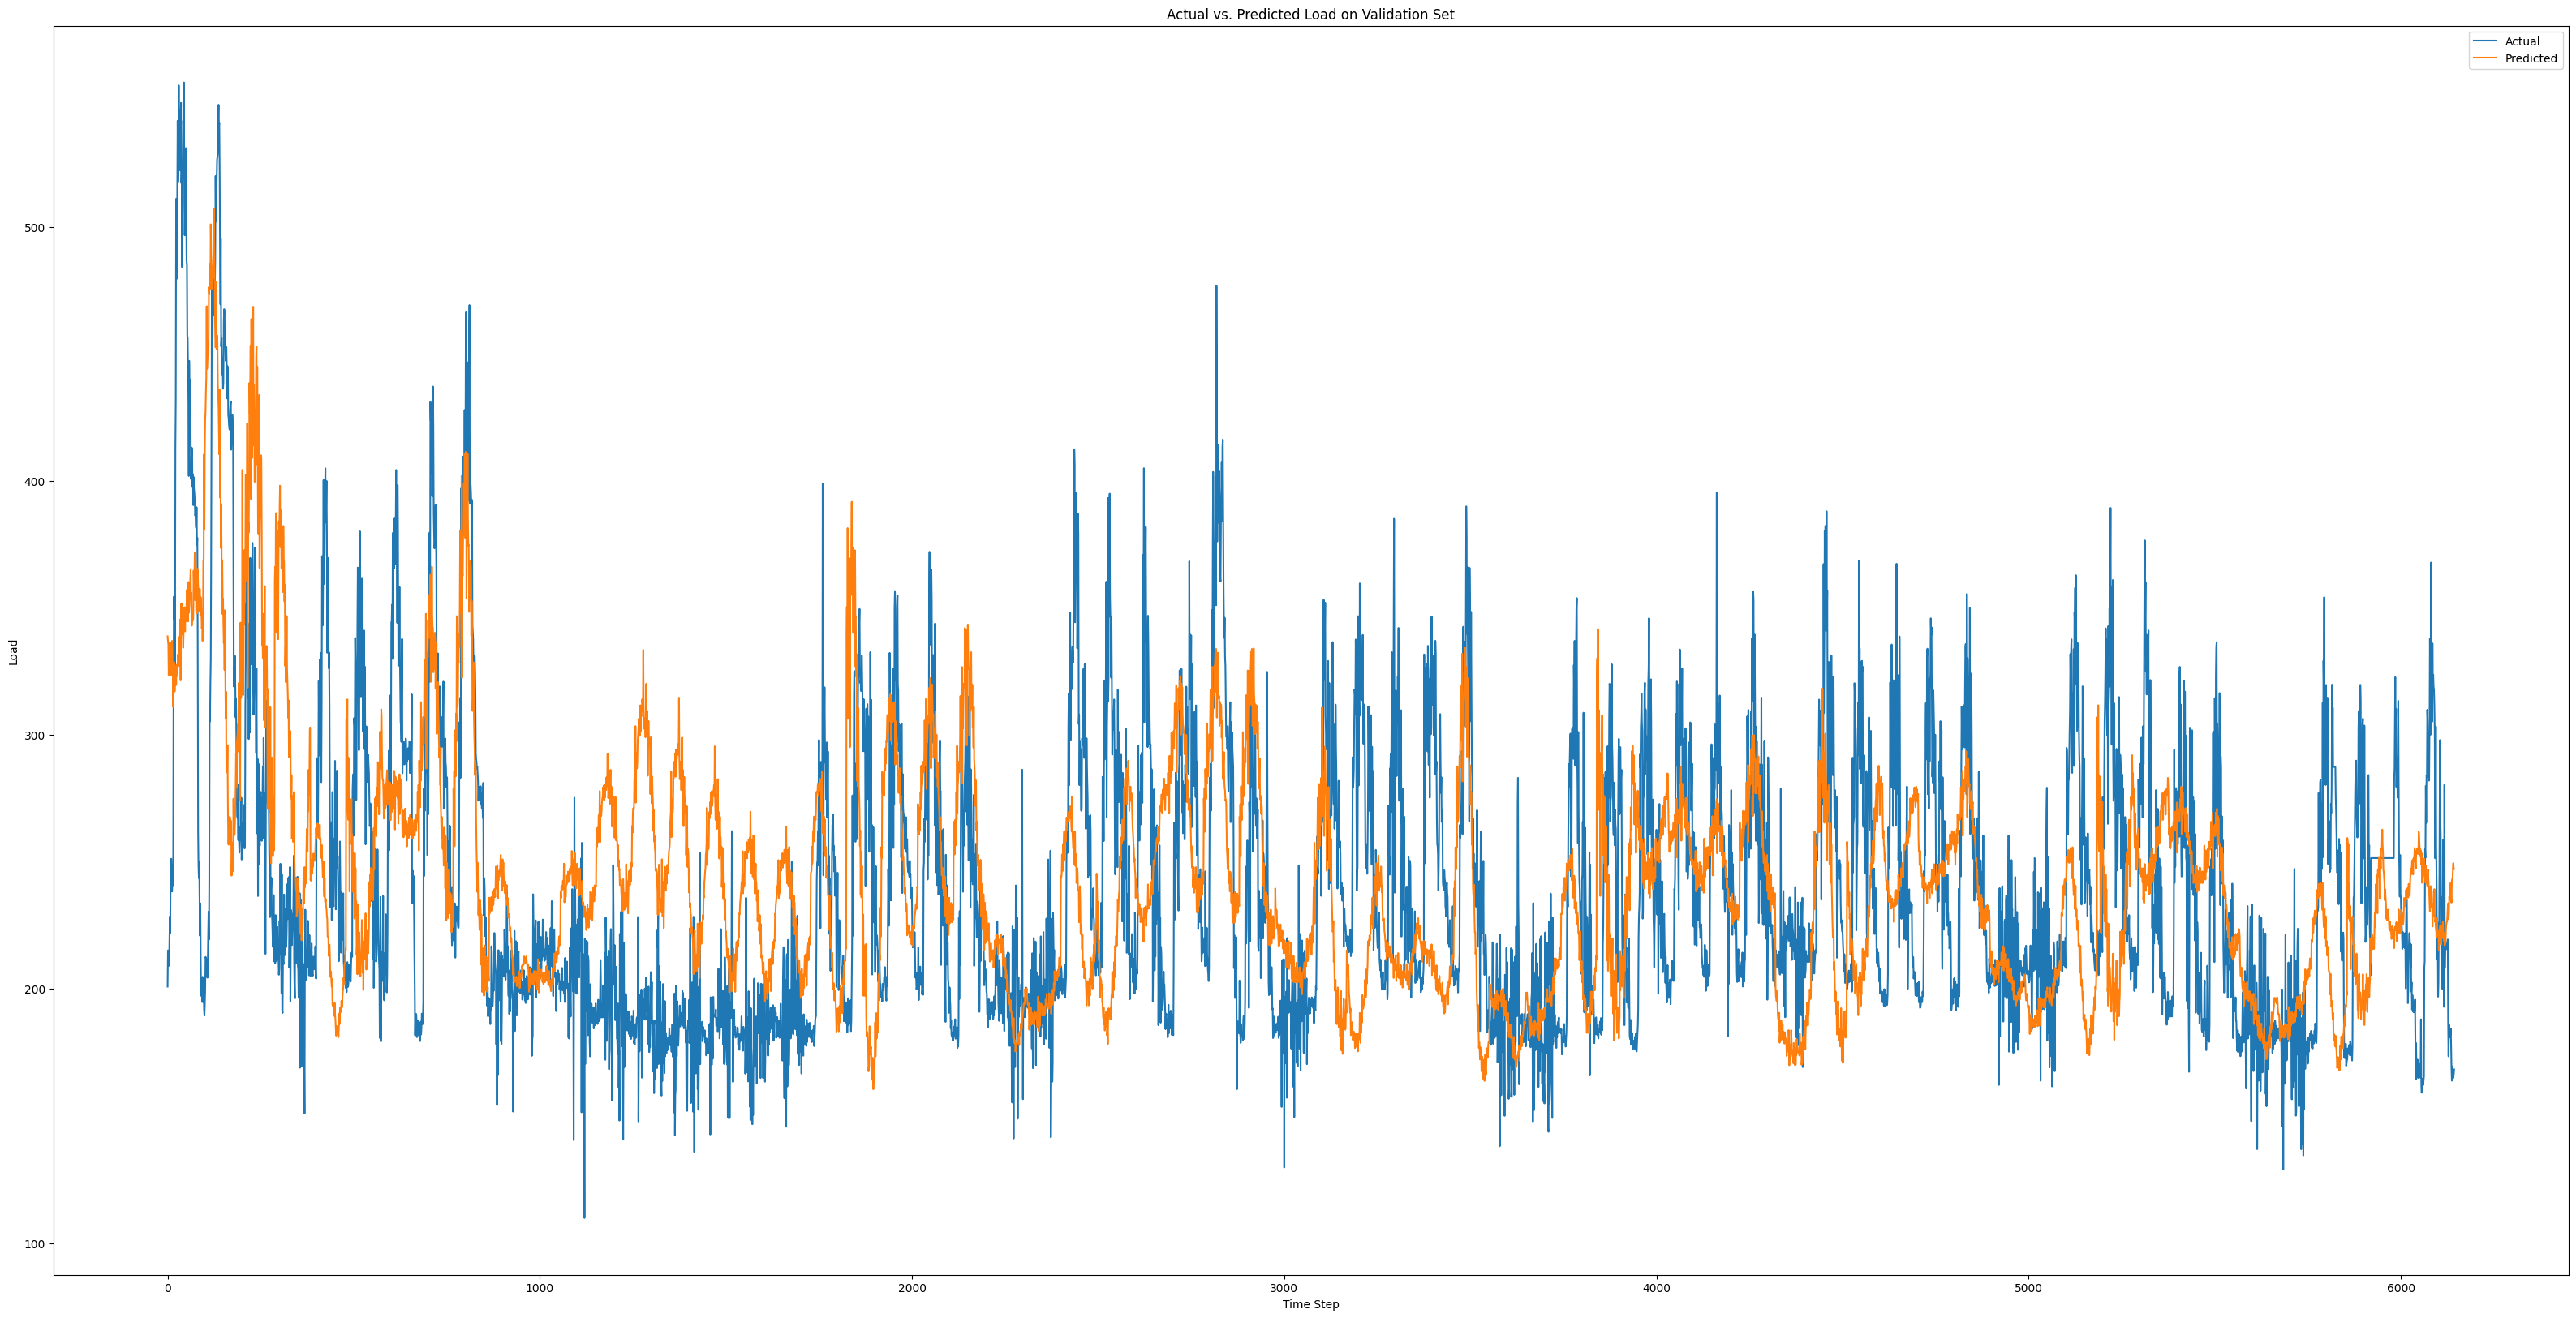

In [22]:
plt.figure(figsize=(40, 20))
plt.plot(actual_load, label='Actual')
plt.plot(predicted_load, label='Predicted')
plt.xlabel('Time Step')
plt.ylabel('Load')
plt.legend()
plt.title('Actual vs. Predicted Load on Validation Set')
plt.show()

In [23]:
calcu = pd.DataFrame({'real':actual_load.flatten(),'pred':predicted_load.flatten()})

In [24]:
calcu = calcu [calcu['real']>10]

In [25]:
calcu['error'] = np.abs((calcu['pred']-calcu['real'])/calcu['real'])

In [26]:
calcu.describe()

,real,pred,error
count,6144.000000,6144.000000,6144.000000
mean,240.792801,242.920242,0.197479
std,61.017395,47.971245,0.160823
min,109.830002,160.482361,0.000015
25%,197.077499,206.842827,0.076126
50%,222.160004,238.149673,0.161392
75%,274.262482,266.432030,0.281045
max,556.759949,507.251709,1.287532


In [64]:
error = np.abs((actual_load-predicted_load)/ actual_load).flatten()

In [65]:
pd.DataFrame(error).describe()

,0
count,5664.000000
mean,inf
std,NaN
min,0.000014
25%,0.051985
50%,0.115636
75%,0.215716
max,inf
